# 05.1 API Key 노출 방지를 위한 환경설정


## 05.1.1 XML을 이용한 API Key 저장

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 연습을 위해 myadmin.xml을 사용했는데 여러분 키를 복사해서 넣고 파일명을 admin.xml로 저장하세요.
%%writefile /content/drive/MyDrive/Data/myadmin.xml
<?xml version="1.0" encoding="utf-8"?>
<body name = "API 서비스키">
    <covid>
    <serviceKey>여기에 코로나 API 서비스키 붙여넣기</serviceKey>
    </covid>
    <sselect>
    <serviceKey>중앙선거관리위원회 선거구 데이터 API 서비스키</serviceKey>
    </sselect>
    <naver_api>
        <client_id>네이버 API 클라이언트 아이디</client_id>
        <client_secret>네이버 API 클라이언트 시크릿</client_secret>
    </naver_api>
</body>

Overwriting /content/drive/MyDrive/Data/myadmin.xml


In [3]:
# 연습을 위해 myadmin.xml을 사용했는데 여러분은 파일명을 admin.xml로 호출하세요.
import bs4
with open("/content/drive/MyDrive/Data/myadmin.xml", 'r') as f:
    xml_doc = f.read()
admin = bs4.BeautifulSoup(xml_doc, features="xml")
print(admin.body.get('name'))
print(admin.body.covid.serviceKey.text)
print(admin.body.naver_api.client_secret.text)

API 서비스키
여기에 코로나 API 서비스키 붙여넣기
네이버 API 클라이언트 시크릿


In [4]:
# 내 admin 정상호출 확인
import bs4
with open("/content/drive/MyDrive/Data/admin.xml", 'r') as f:
    xml_doc = f.read()
admin = bs4.BeautifulSoup(xml_doc, features="xml")
print(admin.body.get("name"))
# print(admin.body.sselect.serviceKey.text)
# print(admin.body.naver_api.client_secret.text)

API 서비스키


## 05.1.2 JSON을 이용한 API Key 저장

In [5]:
# 연습 json 파일 저장
import json
admin={
    'covid' : { "serviceKey" :"여기에 코로나 API 서비스키 붙여넣기" },
    'sselect' : { "serviceKey" :"중앙선거관리위원회 선거구 데이터 API 서비스키" },
    'naver_api':{
        'api_key': 'my_naver_6789',
        'api_secret': "12345" },
    }
with open("/content/drive/MyDrive/Data/myadmin.json", 'w') as f:
    json.dump(admin, f)

In [6]:
# 연습 json 파일 호출
with open('/content/drive/MyDrive/Data/myadmin.json','r') as f:
    s=f.read()
    admin = json.loads(s)
    admin1= json.loads(s)['naver_api']
print(admin['sselect']['serviceKey'])
print(admin['naver_api']['api_key'])
print(admin1['api_key'], admin1['api_secret'])

중앙선거관리위원회 선거구 데이터 API 서비스키
my_naver_6789
my_naver_6789 12345


In [7]:
# 네이버 API 호출
with open('/content/drive/MyDrive/Data/admin.json','r') as f:
    s=f.read()
    admin= json.loads(s)['naver_api']
# print(admin["api_key"], admin["api_secret"])

# 05.2 공공 API를 이용한 데이터 수집

## 05.2.1 공공 API 이용을 위한 준비

공공데이터포털 참조 : https://www.data.go.kr/

산업인력관리공단 국가 자격시험 과목정보 : https://www.data.go.kr/iim/api/selectAPIAcountView.do

* requests.get(url) 데이터는 BS으로 파싱하여 soup.find_all()로 태그를 찾아들어가서 for문으로 정리한다

In [8]:
# 서비스키 등록 및 확인
import bs4
with open("/content/drive/MyDrive/Data/admin.xml", 'r') as f:
    xml_doc = f.read()
admin = bs4.BeautifulSoup(xml_doc, features="xml")
my_key = admin.body.covid.serviceKey.text # 여러분의 서비스키로 입력, 1절 참조
# my_key

In [9]:
url = 'http://openapi.q-net.or.kr/api/service/rest/InquiryExamKmInfo/getList'
params ='?jmCd=1160&pageNo=1&numOfRows=10'
servicekey = f'&serviceKey={my_key}'
# print(url+params+servicekey)

## 05.2.2 공공 API 국가 자격시험 과목정보

In [10]:
# 산업인력관리공단 국가 자격시험 과목정보
import requests
import pandas as pd
from bs4 import BeautifulSoup
res = requests.get(url+params+servicekey)
soup = BeautifulSoup(res.text,'xml')
print(soup.header)
print(soup.body.items.item.prettify()[:400])

<header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header>
<item>
 <dtlTypNm>
  객관식
 </dtlTypNm>
 <jmNm>
  전기공사기사
 </jmNm>
 <kmNm>
  전기응용및공사재료
 </kmNm>
 <kmOrder>
  1
 </kmOrder>
 <kmYn>
  필수과목
 </kmYn>
 <lssnNo>
  1
 </lssnNo>
 <omrQitemCnt>
  20
 </omrQitemCnt>
 <omrStdPnt>
  100
 </omrStdPnt>
 <qitemCnt>
  20
 </qitemCnt>
 <selfldNm>
  선택분야없음
 </selfldNm>
 <seqNo>
  1
 </seqNo>
 <suhmTmMi>
  30
 </suhmTmMi>
</item>



In [11]:
# 받은 정보 종합
rows = []
for item in soup.find_all('item'):
    rows.append({"종목명": item.find("jmNm").text,
                 "과목명": item.find("kmNm").text,
                 "문항수": item.find("qitemCnt").text,
                 "수험시간(분)": item.find("suhmTmMi").text})
df = pd.DataFrame(rows)
df

,종목명,과목명,문항수,수험시간(분)
0,전기공사기사,전기응용및공사재료,20,30
1,전기공사기사,전력공학,20,30
2,전기공사기사,전기기기,20,30
3,전기공사기사,회로이론및제어공학,20,30
4,전기공사기사,전기설비기술기준,20,30
5,전기공사기사,대표과목,1,150


## 05.2.3 공공 API 선거구 데이터

중앙선거관리위원회_선거인수현황 정보 : https://www.data.go.kr/data/15094967/openapi.do

개발계정 상세보기 : https://www.data.go.kr/iim/api/selectAPIAcountView.do

사이트에 들어가서 오픈API 상세정보를 확인해볼 수 있을 뿐만아니라 구현하는 프로그램별로 샘플이 작성되어 있어서 활용이 가능하다.

In [12]:
# Open API에서 요구하는 요청 포맷을 f string 포맷을 이용해서 구조화
from urllib.parse import quote
url = 'http://apis.data.go.kr/9760000/ElcntInfoInqireService/getElpcElcntInfoInqire'
response_type = 'xml'
text1=quote('서울특별시')
text2=quote('종로구')
params = f'?pageNo=1&numOfRows=10&resultType={response_type}&sgId=20200415&sgTypecode=2&sdName={text1}&wiwName={text2}&serviceKey='
my_key = admin.body.sselect.serviceKey.text # 여러분의 서비스키로 입력, 1절 참조
req = url + params + my_key
# req를 출력하여 복사해서 웹브라우저 주소창에 붙여넣기하면 정상적인 결과값이 나와야 됨

In [13]:
# urlopen 이용
from urllib.request import Request, urlopen
response = urlopen(req)
print(response.read().decode()[:300])

<?xml version="1.0" encoding="UTF-8"?><response>
<header>
<resultCode>INFO-00</resultCode>
<resultMsg>NORMAL SERVICE</resultMsg>
</header>
<body>
<items>
  <item>
    <num>1</num>
    <sgId>20200415</sgId>
    <sdName>서울특별시</sdName>
    <sggName>합계</sggName>
    <wiwName>합계</wiwName>
    <emdCount>4


In [14]:
# xml 데이터를 pd dataframe으로 변환
import pandas as pd
from bs4 import BeautifulSoup
response = urlopen(req)
soup = BeautifulSoup(response,'xml')
# print(soup)
rows=[]
for node in soup.find_all('item'):
   rows.append({'시도명' : node.sdName.text, '선거구명' : node.sggName.text, \
                '인구수' : node.ppltCnt.text, '확정선거인수' : node.cfmtnElcnt.text})

df=pd.DataFrame(rows)
df

,시도명,선거구명,인구수,확정선거인수
0,서울특별시,합계,9736986,8465419
1,서울특별시,종로구,151296,134516
2,서울특별시,종로구,151296,134516
3,서울특별시,중구성동구갑,217842,192161
4,서울특별시,중구성동구갑,217842,192161
5,서울특별시,중구성동구을,207715,183779
6,서울특별시,중구성동구을,207715,183779
7,서울특별시,용산구,229623,203233
8,서울특별시,용산구,229623,203233
9,서울특별시,광진구갑,179793,156559


## 05.2.4 공공 API 이용한 JSON 데이터 수집

In [15]:
# json 데이터를 수신하여 json.loads로 디코딩하고 데이터프레임으로 정리
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import json
response_type = 'json'
params = f'?pageNo=1&numOfRows=10&resultType={response_type}&sgId=20200415&sgTypecode=2&sdName={text1}&wiwName={text2}&serviceKey='
req = url + params + my_key
response = urlopen(req).read().decode('utf-8')
items =  json.loads(response)['response']['body']['items']['item']
df = pd.DataFrame(items)
df

,num,sgId,sdName,sggName,wiwName,emdCount,tpgCount,ppltCnt,ntabPpltCnt,frgnrPpltCnt,...,cfmtnManFrgnrCnt,cfmtnFmlElcnt,cfmtnFmlRacnt,cfmtnFmlFrgnrCnt,cfmtnRdvtDccnt,cfmtnNtabRdvtDccnt,cfmtnRdvtManDccnt,cfmtnNtabRdvtManDccnt,cfmtnRdvtFmlDccnt,cfmtnNtabRdvtFmlDccnt
0,1,20200415,서울특별시,합계,합계,424,2252,9736986,29483,0,...,0,4377413,15283,0,12947,7,10093,5,2854,2
1,2,20200415,서울특별시,종로구,합계,17,43,151296,891,0,...,0,69322,451,0,247,0,205,0,42,0
2,3,20200415,서울특별시,종로구,종로구,17,43,151296,891,0,...,0,69322,451,0,247,0,205,0,42,0
3,4,20200415,서울특별시,중구성동구갑,합계,13,52,217842,656,0,...,0,97434,345,0,244,0,202,0,42,0
4,5,20200415,서울특별시,중구성동구갑,성동구,13,52,217842,656,0,...,0,97434,345,0,244,0,202,0,42,0
5,6,20200415,서울특별시,중구성동구을,합계,19,63,207715,1029,0,...,0,95445,575,0,348,1,211,0,137,1
6,7,20200415,서울특별시,중구성동구을,중구,19,63,207715,1029,0,...,0,95445,575,0,348,1,211,0,137,1
7,8,20200415,서울특별시,용산구,합계,16,59,229623,1677,0,...,0,106136,904,0,252,0,200,0,52,0
8,9,20200415,서울특별시,용산구,용산구,16,59,229623,1677,0,...,0,106136,904,0,252,0,200,0,52,0
9,10,20200415,서울특별시,광진구갑,합계,8,42,179793,398,0,...,0,81283,218,0,204,0,166,0,38,0


# 05.3 네이버 API를 이용한 데이터 수집

## 05.3.1 네이버 API 사용을 위한 준비

네이버 open api 신청 홈페이지 : https://developers.naver.com/apps/#/register

네이버뉴스 개발자 홈페이지 : https://developers.naver.com/docs/serviceapi/search/news/news.md#%EB%89%B4%EC%8A%A4

## 05.3.2 네이버 뉴스 API를 이용한 XML 데이터 수집

In [16]:
import urllib
from urllib.request import Request, urlopen
import pandas as pd
import json
from bs4 import BeautifulSoup as bs

with open('/content/drive/MyDrive/Data/admin.json','r') as f:
    s=f.read()
    admin= json.loads(s)['naver_api']
client_id = admin['api_key']
client_secret = admin['api_secret']

In [17]:
keyword = urllib.parse.quote('빅데이터')
url = 'https://openapi.naver.com/v1/search/news.xml?query=' + keyword+'&display=5'
request = Request(url)
request.add_header('X-Naver-Client-Id', client_id)
request.add_header('X-Naver-Client-Secret',client_secret)
response = urlopen(request).read()
soup = bs(response, "xml")
# print(soup.prettify())
news=[]
for item in soup.find_all('item') :
    news.append({"제목": item.title.get_text(),
                 '발행일자': item.pubDate.text,
                 "요약": item.description.text,
                 'Link':item.originallink.text})
df = pd.DataFrame(news)
df

,제목,발행일자,요약,Link
0,[독립 보험대리점 브랜드평판] 1위 인카금융서비스·2위 굿리치,"Wed, 15 May 2024 00:16:00 +0900",인카금융서비스 국내 독립 보험대리점 (GA) 브랜드평판 2024년 5월 <b>빅데이...,https://www.gukjenews.com/news/articleView.htm...
1,[레저 상장기업 브랜드평판] 1위 하나투어·2위 모두투어,"Wed, 15 May 2024 00:16:00 +0900","하나투어 레저 상장기업 브랜드평판 2024년 5월 <b>빅데이터</b> 분석결과, ...",https://www.gukjenews.com/news/articleView.htm...
2,[국토부 공공기관 브랜드평판] 1위 한국도로공사·2위 한국교통안전공단,"Wed, 15 May 2024 00:16:00 +0900","<b>빅데이터</b> 분석결과, 1위 한국도로공사 2위 한국교통안전공단 3위 주택도...",https://www.gukjenews.com/news/articleView.htm...
3,[향수 브랜드평판] 1위 조말론·2위 샤넬·3위 딥디크,"Wed, 15 May 2024 00:16:00 +0900","<b>빅데이터</b> 분석결과, 1위 조말론 향수 2위 샤넬 향수 3위 딥디크 향수...",https://www.gukjenews.com/news/articleView.htm...
4,[데스크의눈] <b>데이터</b> 주권시대 안일한 정부 대응,"Tue, 14 May 2024 23:26:00 +0900","中, 자국앱 통해 <b>데이터</b> 수집 의혹 美·유럽·영국 등서 틱톡 사용금지 ...",http://www.segye.com/newsView/20240514513724?O...


In [18]:
print(df['요약'][1])

하나투어 레저 상장기업 브랜드평판 2024년 5월 <b>빅데이터</b> 분석결과, 1위 하나투어 2위 모두투어 3위 노랑풍선 순으로 분석되었다.​ 한국기업평판연구소는 레저 상장기업 15개 브랜드에 대해서 <b>빅데이터</b>... 


## 05.3.3 네이버 백과사전 API를 이용한 JSON 데이터 수집

참조 : https://developers.naver.com/docs/serviceapi/search/blog/blog.md#%EB%B8%94%EB%A1%9C%EA%B7%B8

json 데이터는 urlopen(request).read()는 바로 json.loads() 할 수 있고 이것은 바로 pd.DataFrame으로 정리 가능

In [19]:
from urllib.parse import quote
from urllib.request import Request, urlopen
import json
import pandas as pd

# 백과사전 스크랩
encText = quote('빅데이터')
url = 'https://openapi.naver.com/v1/search/encyc?query=' + encText+'&display=5'
request = Request(url)
request.add_header('X-Naver-Client-Id', client_id)
request.add_header('X-Naver-Client-Secret',client_secret)
response = urlopen(request).read()
# print(response.decode('utf-8'))

items = json.loads(response)['items']
df = pd.DataFrame(items)
df

,title,link,description,thumbnail
0,<b>빅데이터</b> 정의,https://terms.naver.com/entry.naver?docId=1691...,<b>빅데이터</b>란 디지털 환경에서 생성되는 <b>데이터</b>로 그 규모가 방...,http://openapi-dbscthumb.phinf.naver.net/2157_...
1,<b>빅데이터</b>란,https://terms.naver.com/entry.naver?docId=3386...,<b>빅데이터</b>의 등장] 오늘날 정보통신 분야에서의 화두는 단연 <b>빅데이터...,http://openapi-dbscthumb.phinf.naver.net/4412_...
2,<b>빅 데이터</b>,https://terms.naver.com/entry.naver?docId=2274...,전문가들은 <b>데이터</b>를 분석하는 <b>빅 데이터</b>가 인터넷 이후 기업...,
3,<b>빅데이터</b> 활용,https://terms.naver.com/entry.naver?docId=1691...,<b>빅데이터</b> 활용의 선두 주자는 기업이다. 특히 검색과 전자상거래 기업은 ...,http://openapi-dbscthumb.phinf.naver.net/2157_...
4,<b>빅데이터</b>,https://terms.naver.com/entry.naver?docId=3534...,<b>빅데이터</b>는 <b>데이터</b>에 관한 것이 아니다! &quot;Big ...,http://openapi-dbscthumb.phinf.naver.net/4686_...


In [20]:
# url 리스트 확인
url_list = []
for item in items:
    url_list.append(item['link'])
print(url_list)

['https://terms.naver.com/entry.naver?docId=1691554&cid=42171&categoryId=42183', 'https://terms.naver.com/entry.naver?docId=3386304&cid=58370&categoryId=58370', 'https://terms.naver.com/entry.naver?docId=2274739&cid=42171&categoryId=51120', 'https://terms.naver.com/entry.naver?docId=1691555&cid=42171&categoryId=42183', 'https://terms.naver.com/entry.naver?docId=3534390&cid=58540&categoryId=58540']


In [21]:
# 내용 크롤링
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs

contents=[]
for link in df['link']:
    html = urlopen(link)
    soup = bs(html, "html.parser")
    for p in soup.select_one('div#size_ct').select('p'):
        contents.append(p.text.strip())

print(len(contents))
contents[:10]

89


['빅데이터란 디지털 환경에서 생성되는 데이터로 그 규모가 방대하고, 생성 주기도 짧고, 형태도 수치 데이터뿐 아니라 문자와 영상 데이터를 포함하는 대규모 데이터를 말한다. 빅데이터 환경은 과거에 비해 데이터의 양이 폭증했다는 점과 함께 데이터의 종류도 다양해져 사람들의 행동은 물론 위치정보와 SNS를 통해 생각과 의견까지 분석하고 예측할 수 있다.',
 "디지털 경제의 확산으로 우리 주변에는 규모를 가늠할 수 없을 정도로 많은 정보와 데이터가 생산되는 '빅데이터(Big Data)' 환경이 도래하고 있다. 빅데이터란 과거 아날로그 환경에서 생성되던 데이터에 비하면 그 규모가 방대하고, 생성 주기도 짧고, 형태도 수치 데이터뿐 아니라 문자와 영상 데이터를 포함하는 대규모 데이터를 말한다.PC와 인터넷, 모바일 기기 이용이 생활화되면서 사람들이 도처에 남긴 발자국(데이터)은 기하급수적으로 증가하고 있다(정용찬, 2012a). 쇼핑의 예를 들어 보자. 데이터의 관점에서 보면 과거에는 상점에서 물건을 살 때만 데이터가 기록되었다. 반면 인터넷쇼핑몰의 경우에는 구매를 하지 않더라도 방문자가 돌아다닌 기록이 자동적으로 데이터로 저장된다. 어떤 상품에 관심이 있는지, 얼마 동안 쇼핑몰에 머물렀는지를 알 수 있다. 쇼핑뿐 아니라 은행, 증권과 같은 금융거래, 교육과 학습, 여가활동, 자료검색과 이메일 등 하루 대부분의 시간을 PC와 인터넷에 할애한다. 사람과 기계, 기계와 기계가 서로 정보를 주고받는 사물지능통신(M2M, Machine to Machine)의 확산도 디지털 정보가 폭발적으로 증가하게 되는 이유다.사용자가 직접 제작하는 UCC를 비롯한 동영상 콘텐츠, 휴대전화와 SNS(Social Network Service)에서 생성되는 문자 등은 데이터의 증가 속도뿐 아니라, 형태와 질에서도 기존과 다른 양상을 보이고 있다. 특히 블로그나 SNS에서 유통되는 텍스트 정보는 내용을 통해 글을 쓴 사람의 성향뿐 아니라, 소통하는 상대방의 연결 관계까지도 분석이 가능하다. 게다

In [22]:
print(len(contents))
contents[1]

89


"디지털 경제의 확산으로 우리 주변에는 규모를 가늠할 수 없을 정도로 많은 정보와 데이터가 생산되는 '빅데이터(Big Data)' 환경이 도래하고 있다. 빅데이터란 과거 아날로그 환경에서 생성되던 데이터에 비하면 그 규모가 방대하고, 생성 주기도 짧고, 형태도 수치 데이터뿐 아니라 문자와 영상 데이터를 포함하는 대규모 데이터를 말한다.PC와 인터넷, 모바일 기기 이용이 생활화되면서 사람들이 도처에 남긴 발자국(데이터)은 기하급수적으로 증가하고 있다(정용찬, 2012a). 쇼핑의 예를 들어 보자. 데이터의 관점에서 보면 과거에는 상점에서 물건을 살 때만 데이터가 기록되었다. 반면 인터넷쇼핑몰의 경우에는 구매를 하지 않더라도 방문자가 돌아다닌 기록이 자동적으로 데이터로 저장된다. 어떤 상품에 관심이 있는지, 얼마 동안 쇼핑몰에 머물렀는지를 알 수 있다. 쇼핑뿐 아니라 은행, 증권과 같은 금융거래, 교육과 학습, 여가활동, 자료검색과 이메일 등 하루 대부분의 시간을 PC와 인터넷에 할애한다. 사람과 기계, 기계와 기계가 서로 정보를 주고받는 사물지능통신(M2M, Machine to Machine)의 확산도 디지털 정보가 폭발적으로 증가하게 되는 이유다.사용자가 직접 제작하는 UCC를 비롯한 동영상 콘텐츠, 휴대전화와 SNS(Social Network Service)에서 생성되는 문자 등은 데이터의 증가 속도뿐 아니라, 형태와 질에서도 기존과 다른 양상을 보이고 있다. 특히 블로그나 SNS에서 유통되는 텍스트 정보는 내용을 통해 글을 쓴 사람의 성향뿐 아니라, 소통하는 상대방의 연결 관계까지도 분석이 가능하다. 게다가 사진이나 동영상 콘텐츠를 PC를 통해 이용하는 것은 이미 일반화되었고 방송 프로그램도 TV수상기를 통하지 않고 PC나 스마트폰으로 보는 세상이다.트위터(twitter)에서만 하루 평균 1억 5500만 건이 생겨나고 유튜브(YouTube)의 하루 평균 동영상 재생건수는 40억 회에 이른다. 글로벌 데이터 규모는 2012년에 2.7제타바이트(zettabyt

# 05.4 구글 Pytrends 라이브러리와 뉴스 검색 결과 활용

## 05.4.1 Pytrends를 이용한 트렌드 검색

In [23]:
# Colab 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
!apt install fonts-nanum fonts-nanum-extra
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-extra
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 3s (11.2 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (202

In [24]:
!pip install pytrends

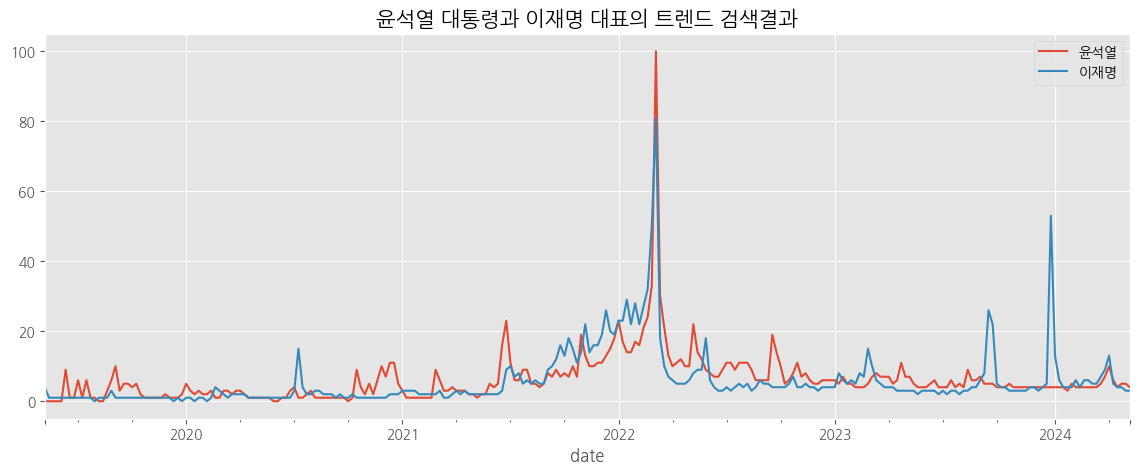

In [25]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
keyword1 = "윤석열"
keyword2 = "이재명"
period = "today 5-y"
trend_obj = TrendReq()
trend_obj.build_payload(kw_list=[keyword1, keyword2], timeframe=period, geo="KR")
trend_df = trend_obj.interest_over_time()
plt.rc('font', family='NanumGothic')
plt.style.use("ggplot")
plt.figure(figsize=(14,5))
trend_df[keyword1].plot()
trend_df[keyword2].plot()
plt.title("윤석열 대통령과 이재명 대표의 트렌드 검색결과", size=15)
plt.legend(loc="best")
plt.show()

## 05.4.2 뉴스 검색 결과 정리

In [26]:
#로봇배제기준 확인
import requests
resp = requests.get('https://www.mk.co.kr/robots.txt')
print(resp.text)

User-agent: *
Disallow: /search

User-agent: Googlebot
Allow: /
User-agent: Googlebot-News
Allow: /
User-agent: Googlebot-Image
Allow: /
User-agent: Mediapartners-Google
Allow: /
User-agent: popIn_Agent
Allow: /
User-agent: Bingbot
Allow: /
User-agent: MSNBot 
Allow: /
User-agent: MSNBot-Media 
Allow: /
User-agent: BingPreview
Allow: /
User-agent: Facebot
Allow: /
User-agent: Yeti
Allow: /
User-agent: facebookexternalhit/1.1
Allow: / 
User-agent: facebookexternalhit/1.1 (+http://www.facebook.com/externalhit_uatext.php)
Allow: /
User-agent: Twitterbot
Allow: /
User-agent: grapeshot
Disallow:
User-agent: Google Search Console
Allow: /
User-agent: Googlebot/2.1
Allow: /
User-agent: Googlebot-Smartphone
Allow: /

User-agent: *
Disallow: /

Sitemap: https://www.mk.co.kr/sitemap/sections/
Sitemap: https://www.mk.co.kr/sitemap/latest-articles/
Sitemap: https://www.mk.co.kr/sitemap/daily-articles/
Sitemap: https://www.mk.co.kr/sitemap/daily-images/

#DaumWebMasterTool:efc5991982b659e20b2b33018

In [27]:
# 구글 뉴스 검색어
import requests
from bs4 import BeautifulSoup as bs
import urllib
import pandas as pd

keyword ='미래핵심 기술'
url = f"https://www.mk.co.kr/search?word={keyword}"
# print(url)

In [28]:
# 구글 검색 페이지 파싱과 뉴스 제목 검색
resp = requests.get(url)
html_src = resp.text
soup = bs(html_src, 'html.parser')
#AAA > div.inner > div > div.tab-contents > div > div.tab-contents > div > ul > li:nth-child(1) > div:nth-child(1) > h3.board-list.h3.pc_only > a
news_items = soup.select('li.news_node')
# news_items

In [29]:
# 특정 주제의 뉴스 링크 확보
links=[]; titles=[];
for item in news_items:
    titles.append(item.select_one('h3.news_ttl').text)
    link = item.find('a').get("href")
    links.append(link)
result = {'Title' : titles, 'Links':links}
df = pd.DataFrame(result)
df

,Title,Links
0,中 숨통 조이는 바이든 …'슈퍼 301조' 전방위 관세폭탄,https://www.mk.co.kr/news/world/11015840
1,"[속보] 美, 중국산 전기차 관세 25→100%·태양전지 25→50% 대폭 인상",https://www.mk.co.kr/news/business/11015727
2,"[단독] SK온 배터리, 현대차 신형 상용차에 탑재",https://www.mk.co.kr/news/business/11015702
3,"""2027년까지 국산 mRNA 백신 개발""",https://www.mk.co.kr/news/society/11015581
4,"[매경춘추] 우리 동네, SMR",https://www.mk.co.kr/news/contributors/11015553
5,"관심 커진 RWA 코인, 블록체인 대중적 사용 이끌까",https://www.mk.co.kr/news/culture/11015525
6,지방소멸 해결사 ‘치유산업’ 뜬다,https://www.mk.co.kr/news/economy/11015480
7,한화시스템 ‘AESA 레이다’ 안테나 첫 해외 수출…유럽 대표 방산기업에 공급,https://www.mk.co.kr/news/business/11015348
8,주 6일제란 화두 [김선걸 칼럼],https://www.mk.co.kr/news/columnists/11012635
9,"""인공지능이 AR안경 성장 앞당겨…스마트폰만큼 널리 쓰일 것""",https://www.mk.co.kr/news/world/11014547


In [30]:
# 웹 크롤링 결과 데이터프레임 정리 : 기사제목 추출하는 것처럼 select문과 find문 결합해서 사용하면 유용

contents = []
for i in range(len(links)):
    url=links[i]
    resp = requests.get(url)
    html_src = resp.text
    soup = bs(html_src, "html.parser")
    text = ''
    for para in soup.select('div.news_cnt_detail_wrap'):
        text += para.text.strip()
    if bool(text) : contents.append(text)
    else : contents.append('내용 없음')

data = {'제목':titles, '기사 내용' : contents}
df = pd.DataFrame(data)
df

,제목,기사 내용
0,中 숨통 조이는 바이든 …'슈퍼 301조' 전방위 관세폭탄,180억달러 규모 수입품 대상…中 견제·표심잡기 승부수전기차 관세 현행 25%→10...
1,"[속보] 美, 중국산 전기차 관세 25→100%·태양전지 25→50% 대폭 인상",사진 확대 연설하는 바이든 미국 대통령. [사진 = AP 연합뉴스] 오는 1...
2,"[단독] SK온 배터리, 현대차 신형 상용차에 탑재",에너지 밀도 9% 높이면서20분이면 80% 급속 충전택배·캠핑 등 용도에 특화'목적...
3,"""2027년까지 국산 mRNA 백신 개발""",지영미 질병관리청장또다른 팬데믹 대응 계획\n\n\n 사진 확대 \...
4,"[매경춘추] 우리 동네, SMR",사진 확대 \n최근 우리 회사는 경주시와 탄소중립 도시를 만들기 위한 협약을...
5,"관심 커진 RWA 코인, 블록체인 대중적 사용 이끌까",사진 확대 글로벌 최대 자산 운용사인 블랙록이 불붙인 RWA(Real Wor...
6,지방소멸 해결사 ‘치유산업’ 뜬다,"스마트치유산업포럼·매일경제 공동‘지방 미래, 치유산업으로 열다’ 주제24일 서울 양..."
7,한화시스템 ‘AESA 레이다’ 안테나 첫 해외 수출…유럽 대표 방산기업에 공급,AESA 레이더 공동 개발도 추진아시아·태평양 지역에도 수출 기대 사진...
8,주 6일제란 화두 [김선걸 칼럼],내용 없음
9,"""인공지능이 AR안경 성장 앞당겨…스마트폰만큼 널리 쓰일 것""",아사프 아슈케나지 에브리사이트 CEOF16 조종사 출신 노하우 활용가벼운 렌즈 저렴...


# 05.5 한국어 말뭉치 Korpora를 통한 텍스트 데이터 수집

## 05.5.1 Korpora를 통한 한국어 자연어처리 말뭉치 수집

In [31]:
!pip install Korpora
from Korpora import Korpora
Korpora.corpus_list()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.1 MB/s eta 0:00:00


{'kcbert': 'beomi@github 님이 만드신 KcBERT 학습데이터',
 'korean_chatbot_data': 'songys@github 님이 만드신 챗봇 문답 데이터',
 'korean_hate_speech': '{inmoonlight,warnikchow,beomi}@github 님이 만드신 혐오댓글데이터',
 'korean_parallel_koen_news': 'jungyeul@github 님이 만드신 병렬 말뭉치',
 'korean_petitions': 'lovit@github 님이 만드신 2017.08 ~ 2019.03 청와대 청원데이터',
 'kornli': 'KakaoBrain 에서 제공하는 Natural Language Inference (NLI) 데이터',
 'korsts': 'KakaoBrain 에서 제공하는 Semantic Textual Similarity (STS) 데이터',
 'kowikitext': 'lovit@github 님이 만드신 wikitext 형식의 한국어 위키피디아 데이터',
 'namuwikitext': 'lovit@github 님이 만드신 wikitext 형식의 나무위키 데이터',
 'naver_changwon_ner': '네이버 + 창원대 NER shared task data',
 'nsmc': 'e9t@github 님이 만드신 Naver sentiment movie corpus v1.0',
 'question_pair': 'songys@github 님이 만드신 질문쌍(Paired Question v.2)',
 'modu_news': '국립국어원에서 만든 모두의 말뭉치: 뉴스 말뭉치',
 'modu_messenger': '국립국어원에서 만든 모두의 말뭉치: 메신저 말뭉치',
 'modu_mp': '국립국어원에서 만든 모두의 말뭉치: 형태 분석 말뭉치',
 'modu_ne': '국립국어원에서 만든 모두의 말뭉치: 개체명 분석 말뭉치',
 'modu_spoken': '국립국어원에서 만든 모두의 말뭉치: 구어 

In [32]:
Korpora.fetch("korsts")
corpus = Korpora.load("korsts")
import pandas as pd
df = pd.read_csv('/root/Korpora/korsts/sts-test.tsv', delimiter='\t')
df[:2]

[korsts] download sts-train.tsv: 1.05MB [00:00, 17.9MB/s]
[korsts] download sts-dev.tsv: 311kB [00:00, 5.38MB/s]
[korsts] download sts-test.tsv: 254kB [00:00, 5.17MB/s]



    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/kakaobrain/KorNLUDatasets
    References :
        - Ham, J., Choe, Y. J., Park, K., Choi, I., & Soh, H. (2020). KorNLI and KorSTS: New Benchmark
           Datasets for Korean Natural Language Understanding. arXiv preprint arXiv:2004.03289.
           (https://arxiv.org/abs/2004.03289)

    This is the dataset repository for our paper
    "KorNLI and KorSTS: New Benchmark Datasets for Korean Natural Language Understanding."
    (https://arxiv.org/abs/2004.03289)
    We introduce KorNLI and KorSTS, which are NLI and STS datasets in Korean.

    # License
    Creative Commons Attribution-ShareAlike license (CC BY-SA 4.0)
    Details in https://creativecommons.org/licenses

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.


In [33]:
df

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,24,2.5,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,main-captions,MSRvid,2012test,33,3.6,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,main-captions,MSRvid,2012test,45,5.0,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,main-captions,MSRvid,2012test,63,4.2,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,main-captions,MSRvid,2012test,66,1.5,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.
...,...,...,...,...,...,...,...
1374,main-news,headlines,2016,1354,0.0,필리핀과 캐나다는 더 나아가 관계를 증진시키겠다고 약속한다.,필리핀은 여객선 침몰 후 100명을 구한다.
1375,main-news,headlines,2016,1360,1.0,이스라엘은 팔레스타인인의 예루살렘의 구 시가지 출입을 금지한다.,팔레스타인인과 이스라엘 두 국가 해결안은 그림의 떡
1376,main-news,headlines,2016,1368,1.0,비밀경호국에 대해 얼마나 알고 계십니까?,양측 의원들은 비밀경호국에 분노를 표출한다
1377,main-news,headlines,2016,1420,0.0,이란 회담이 재개되면서 오바마는 사우디의 두려움을 달래기 위해 고군분투하고 있다.,미얀마는 일요일 투표를 위한 유권자 명단을 확정하기 위해 고군분투하고 있다.
